In [1]:
# dataset setup
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# read all the words in the file
words = open("../names.txt").read().splitlines()

# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { ch: i + 1 for i, ch in enumerate(chars) }
stoi["."] = 0
itos = { i: ch for ch, i in stoi.items() }
vocab_size = len(itos)

# build the dataset
block_size = 3  # using 3 contiguous characters to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]    # crop and append
    return torch.tensor(X), torch.tensor(Y)

# split the dataset, randomly
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xtest, Ytest = build_dataset(words[n2:])    # 10%


In [4]:
# parameters setting
n_embd = 10     # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of hidden units

g = torch.Generator().manual_seed(2147483647)   # consistent with Andrej's settings 
C = torch.randn((vocab_size, n_embd),                    generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn((n_hidden,),                       generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn((vocab_size,),                     generator=g)

parameters = [C, W1, b1, W2, b2]        # collect all parameters
print("#parameters in total:", sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

#parameters in total: 11897


In [5]:
# model training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]     # batch X, Y

    # forward pass
    emb = C[Xb]                                   # character embeddings
    embcat = emb.view(emb.shape[0], -1)           # concatenate the vectors
    hpreact = embcat @ W1 + b1                    # pre-activation
    h = torch.tanh(hpreact)                       # hidden layer
    logits = h @ W2 + b2                          # output layer
    loss = F.cross_entropy(logits, Yb)            # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01              # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: loss={loss.item():.4f}")
    lossi.append(loss.item())


      0/ 200000: loss=25.3606
  10000/ 200000: loss=2.8773
  20000/ 200000: loss=2.9392
  30000/ 200000: loss=2.2645
  40000/ 200000: loss=2.3070
  50000/ 200000: loss=2.1340
  60000/ 200000: loss=2.4111
  70000/ 200000: loss=2.1855
  80000/ 200000: loss=2.2445
  90000/ 200000: loss=2.1231
 100000/ 200000: loss=2.1515
 110000/ 200000: loss=1.9242
 120000/ 200000: loss=1.9465
 130000/ 200000: loss=2.0818
 140000/ 200000: loss=2.1904
 150000/ 200000: loss=1.9120
 160000/ 200000: loss=2.1915
 170000/ 200000: loss=2.0538
 180000/ 200000: loss=2.0643
 190000/ 200000: loss=2.3519


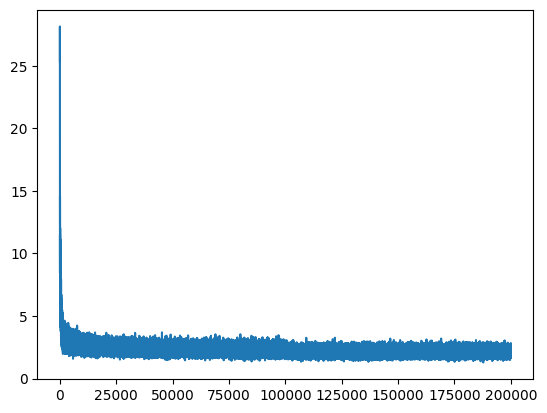

In [6]:
plt.plot(lossi)

In [8]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtrain, Ytrain),
        "val": (Xdev, Ydev),
        "test": (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

split_loss("train")
split_loss("val")

train loss: 2.1244
val loss: 2.1692


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift and track
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nihayla.
rethan.
endraegelie.
koreliah.
milopalekenslen.
narleitzion.
kalin.
shubergiairiel.
kindreelynn.
nohalanu.
zayven.
kylani.
els.
kayshan.
kyla.
hil.
salynn.
